In [129]:
#import required packages 

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

In [97]:
train_df= pd.read_csv('train_clean.csv')
test_df= pd.read_csv('test_clean.csv')

Visualising and dealing with missing values

In [98]:
z = train_df.isnull().sum()[train_df.isnull().sum()>0].to_frame().rename(columns={0:"No. of Missing values"})
z["% of Missing values"] = round(train_df.isnull().sum()[train_df.isnull().sum()>0]*100/len(train_df),2)
z

,No. of Missing values,% of Missing values
HomePlanet,201,2.31
CryoSleep,217,2.50
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39
Spa,183,2.11
VRDeck,188,2.16


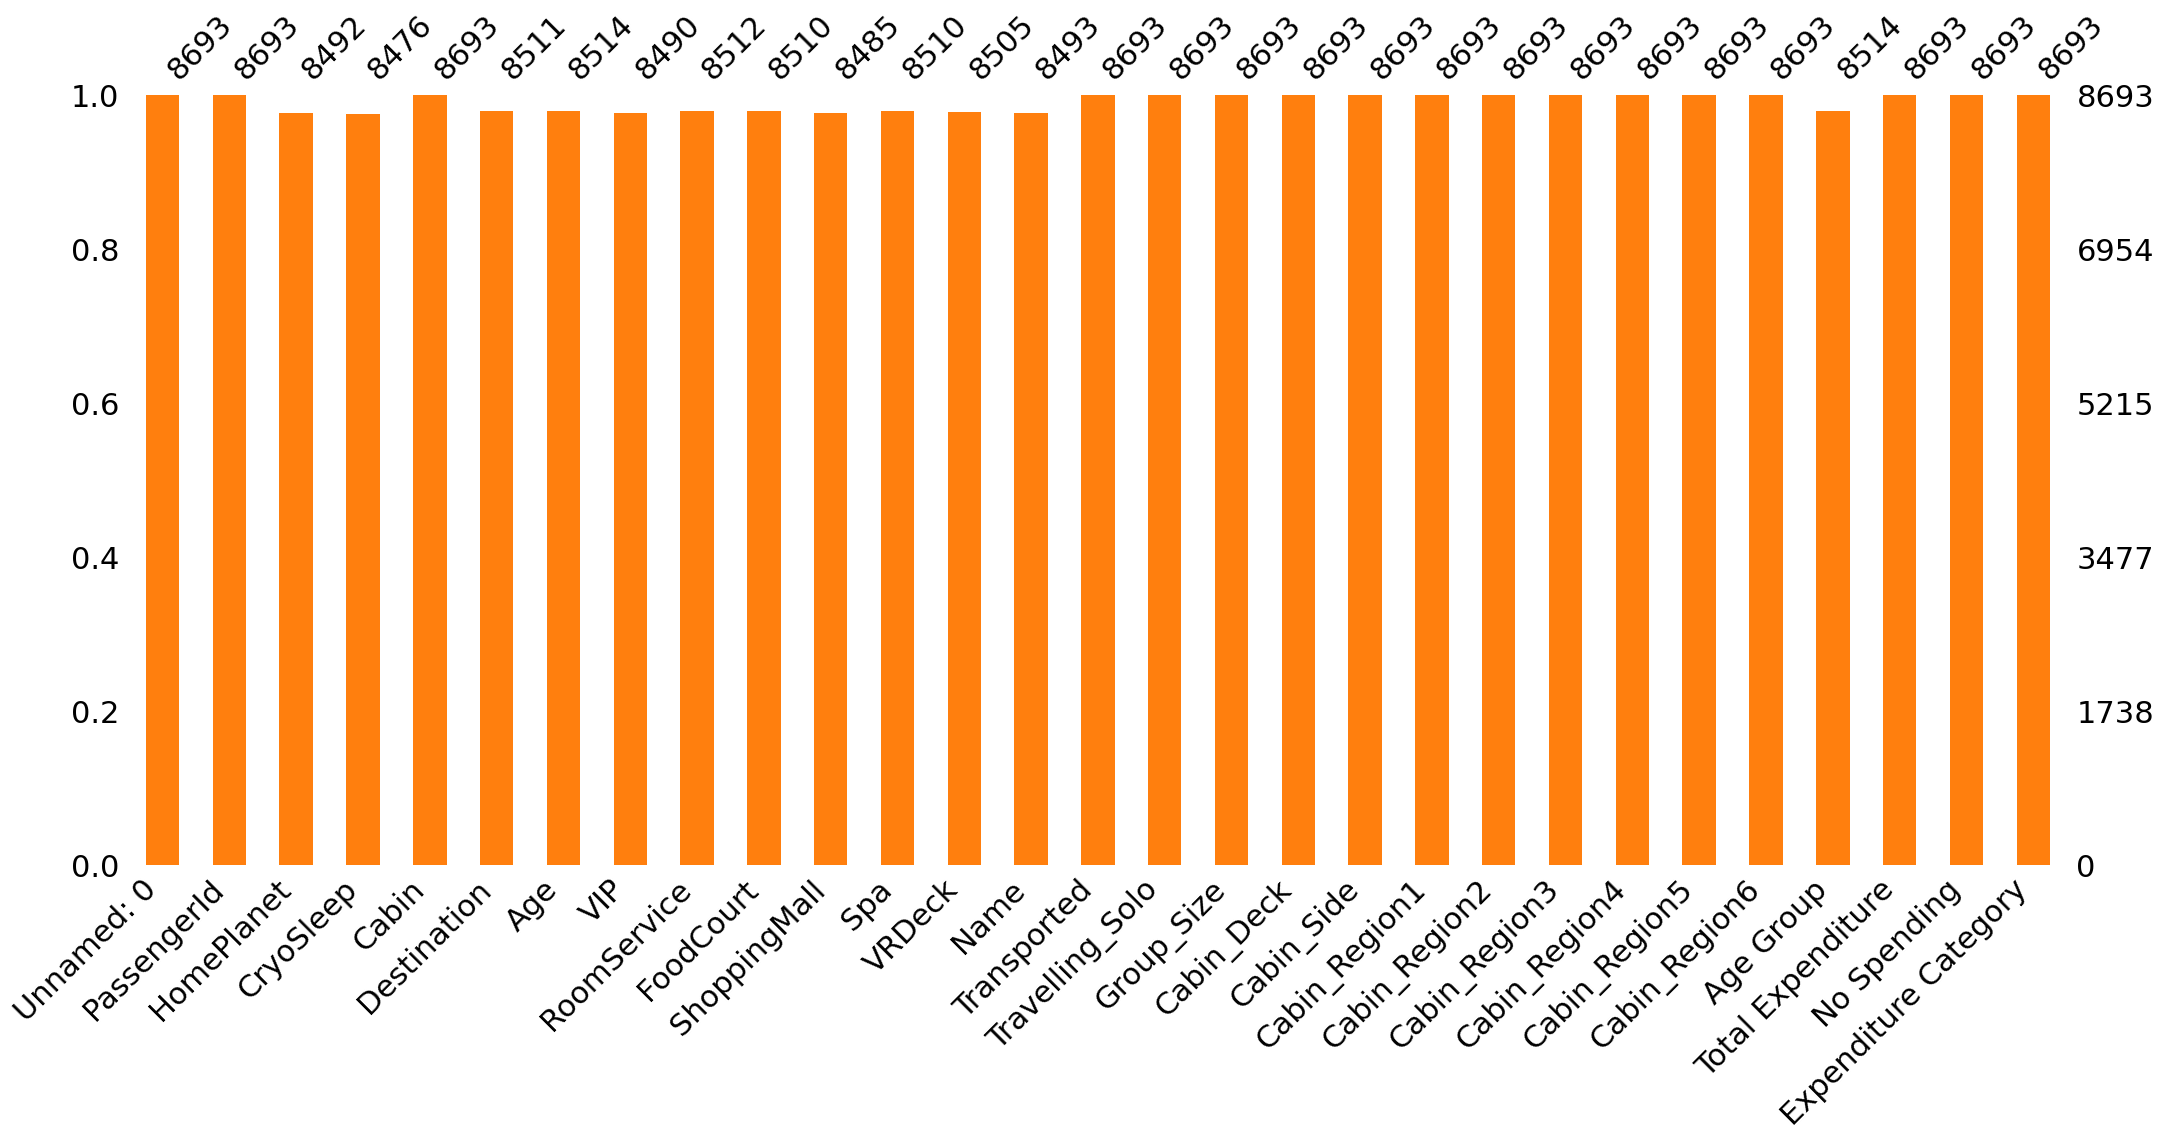

In [99]:
import missingno as msno

msno.bar(train_df,color="C1",fontsize=22)
plt.show()

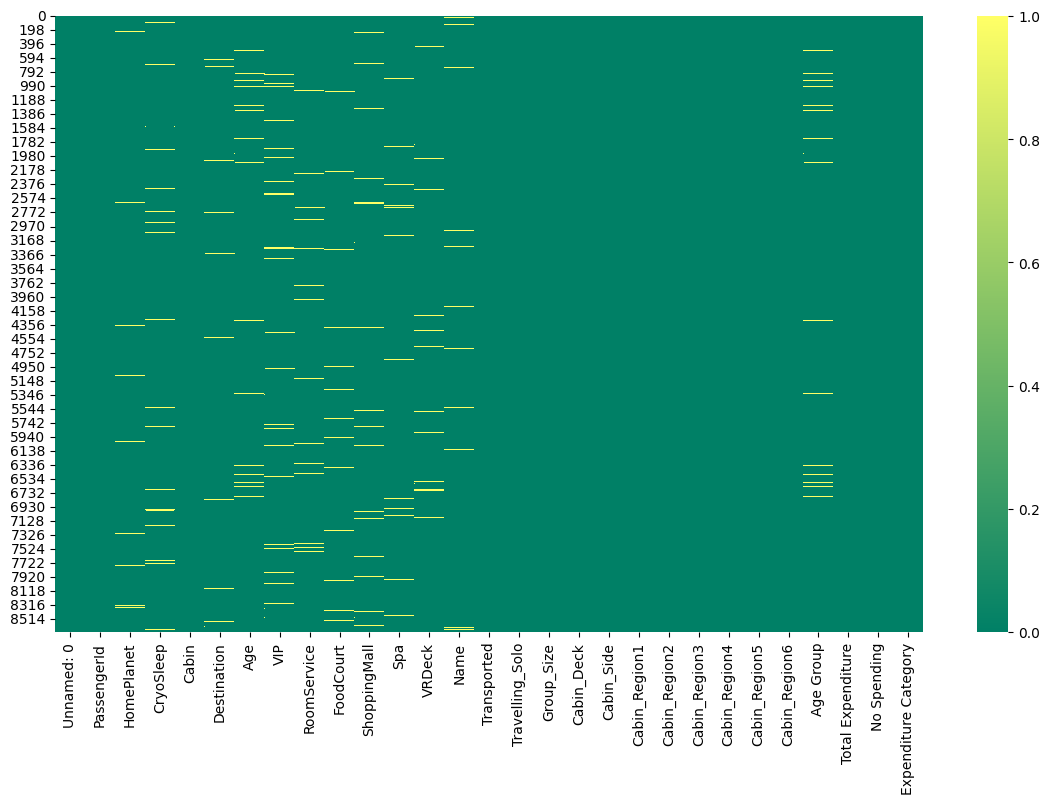

In [100]:
plt.figure(figsize=(14,8))
sns.heatmap(train_df.isnull(),cmap="summer")
plt.show()

Handling missing values - first split the data into categorical and continuous features 

In [101]:
cat_cols = train_df.select_dtypes(include=["object","bool"]).columns.tolist()
cat_cols.remove("Transported")
num_cols = train_df.select_dtypes(include=["int","float"]).columns.tolist()

In [102]:
print("Categorical Columns:",cat_cols)
print("\n","-"*120)
print("\nNumerical Columns:",num_cols)

Categorical Columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'Travelling_Solo', 'Cabin_Deck', 'Cabin_Side', 'Cabin_Region1', 'Cabin_Region2', 'Cabin_Region3', 'Cabin_Region4', 'Cabin_Region5', 'Cabin_Region6', 'Age Group', 'No Spending', 'Expenditure Category']

 ------------------------------------------------------------------------------------------------------------------------

Numerical Columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total Expenditure']


using simple imputer library to fill missing values-- the mode is used to fill categorical values and the median used for numerical values

In [103]:
imputer1 = SimpleImputer(strategy="most_frequent")     ##To fill Categorical Features.
imputer2 = SimpleImputer(strategy="median")   ##To fill numeircal features.

In [104]:
def fill_missingno(df):
    df[cat_cols] = imputer1.fit_transform(df[cat_cols])
    df[num_cols] = imputer2.fit_transform(df[num_cols])

In [105]:
fill_missingno(train_df)
fill_missingno(test_df)

In [106]:
print("Missing numbers left in train_df is:",train_df.isnull().sum().sum())
print("Missing numbers left in test_df is:",test_df.isnull().sum().sum())

Missing numbers left in train_df is: 0
Missing numbers left in test_df is: 0


Check the duplicacy in the data again after filling in missing values

In [107]:
print("Duplicate values in training data is: ",train_df.duplicated().sum())
print("Duplicate values in testing data is: ",test_df.duplicated().sum())

Duplicate values in training data is:  0
Duplicate values in testing data is:  0


Also check again the cardinality of categorical features- we will want to remove features with a high cardinality as these will not supply additional predictive power 

In [108]:
print("Cardinality of features in numerical data is: ")
print(train_df.select_dtypes(include=["object"]).nunique())
print("\n","-"*50)
print("\nCardinality of features in categorical data is: ")
print(test_df.select_dtypes(include=["object"]).nunique())

Cardinality of features in numerical data is: 
PassengerId             8693
HomePlanet                 3
Cabin                   6561
Destination                3
Name                    8473
Cabin_Deck                 8
Cabin_Side                 2
Age Group                  6
Expenditure Category       4
dtype: int64

 --------------------------------------------------

Cardinality of features in categorical data is: 
PassengerId             4277
HomePlanet                 3
Cabin                   3266
Destination                3
Name                    4176
Cabin_Deck                 8
Cabin_Side                 2
Age Group                  6
Expenditure Category       4
dtype: int64


In [109]:
##therefore we want to remove passenger ID, cabin, and Name from our features 

##Extracting passengerId from test data because qe need this for submitting our predictions on kaggle.
pass_df = test_df[["PassengerId"]]

cols = ["PassengerId","Cabin","Name"]
train_df.drop(columns =cols, inplace=True)
test_df.drop(columns=cols, inplace=True)


train_df.drop(columns ='Unnamed: 0', inplace=True)
test_df.drop(columns='Unnamed: 0', inplace=True)

In [110]:
#gethering statistical information on numerical features 

train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8693.0,28.790291,14.341404,0.0,20.0,27.0,37.0,79.0
RoomService,8693.0,220.009318,660.519050,0.0,0.0,0.0,41.0,14327.0
FoodCourt,8693.0,448.434027,1595.790627,0.0,0.0,0.0,61.0,29813.0
ShoppingMall,8693.0,169.572300,598.007164,0.0,0.0,0.0,22.0,23492.0
Spa,8693.0,304.588865,1125.562559,0.0,0.0,0.0,53.0,22408.0
VRDeck,8693.0,298.261820,1134.126417,0.0,0.0,0.0,40.0,24133.0
Group_Size,8693.0,2.035546,1.596347,1.0,1.0,1.0,3.0,8.0
Total Expenditure,8693.0,1440.866329,2803.045694,0.0,0.0,716.0,1441.0,35987.0


In [111]:
#calculate the skew 

print('The skew for Total Expenditure is:',skew(train_df['Total Expenditure']))
print('The skew for Room Service is:',skew(train_df['RoomService']))
print('The skew for Food Court is:',skew(train_df['FoodCourt']))
print('The skew for Shopping Mall is:',skew(train_df['ShoppingMall']))
print('The skew for Spa is:',skew(train_df['Spa']))
print('The skew for VR Deck is:',skew(train_df['VRDeck']))

The skew for Total Expenditure is: 4.416825887029282
The skew for Room Service is: 6.396661848251665
The skew for Food Court is: 7.176276632484426
The skew for Shopping Mall is: 12.761639609477124
The skew for Spa is: 7.715118060862281
The skew for VR Deck is: 7.9031903980797065


In [112]:
#we can observe in RoomService, FoodCourt, ShoppingMall, 
#Spa & VRDeck more than 50 percentile of data are equal to 0

#we saw this when visualising the features and they were highly right skewed,
#we can therefore say there is a large number of outliers with large values in the 
#data 

#we can transform these outliers to the normal distribution using Log Transformation

#log transformation is a good method to use when there are no zero or neagtive values
#and is not as senstive to outliers as mixmax scaler
#a log transformation scales values and fits the data to a
#normal distribution- this is needed when fitting certain ML models like linear,
#logistic regression

#see this article for more info about skewness in data -
#https://medium.com/@data.science.enthusiast/data-scaling-and-skewness-handling-c3800f7c9b0a

In [113]:
cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Total Expenditure']

for value in cols:
    train_df[value] = np.log(1+train_df[value])
    test_df[value]=np.log(1+test_df[value])

In [114]:
#calculate the skew again

print('The skew for Total Expenditure is:',skew(train_df['Total Expenditure']))
print('The skew for Room Service is:',skew(train_df['RoomService']))
print('The skew for Food Court is:',skew(train_df['FoodCourt']))
print('The skew for Shopping Mall is:',skew(train_df['ShoppingMall']))
print('The skew for Spa is:',skew(train_df['Spa']))
print('The skew for VR Deck is:',skew(train_df['VRDeck']))

#we can see the skew measure has decreased but data is still above one- regarded as 
#highly skewed -- likely due to v large majority of zero values

The skew for Total Expenditure is: -0.21239880702649794
The skew for Room Service is: 1.1496680630557234
The skew for Food Court is: 1.1429802289558866
The skew for Shopping Mall is: 1.2382845464635548
The skew for Spa is: 1.1221300902857
The skew for VR Deck is: 1.1932112408166384


C:\Users\sophie.porton\AppData\Local\Temp\ipykernel_77812\1713760797.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[i],color="green")
C:\Users\sophie.porton\AppData\Local\Temp\ipykernel_77812\1713760797.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[i],color="green")


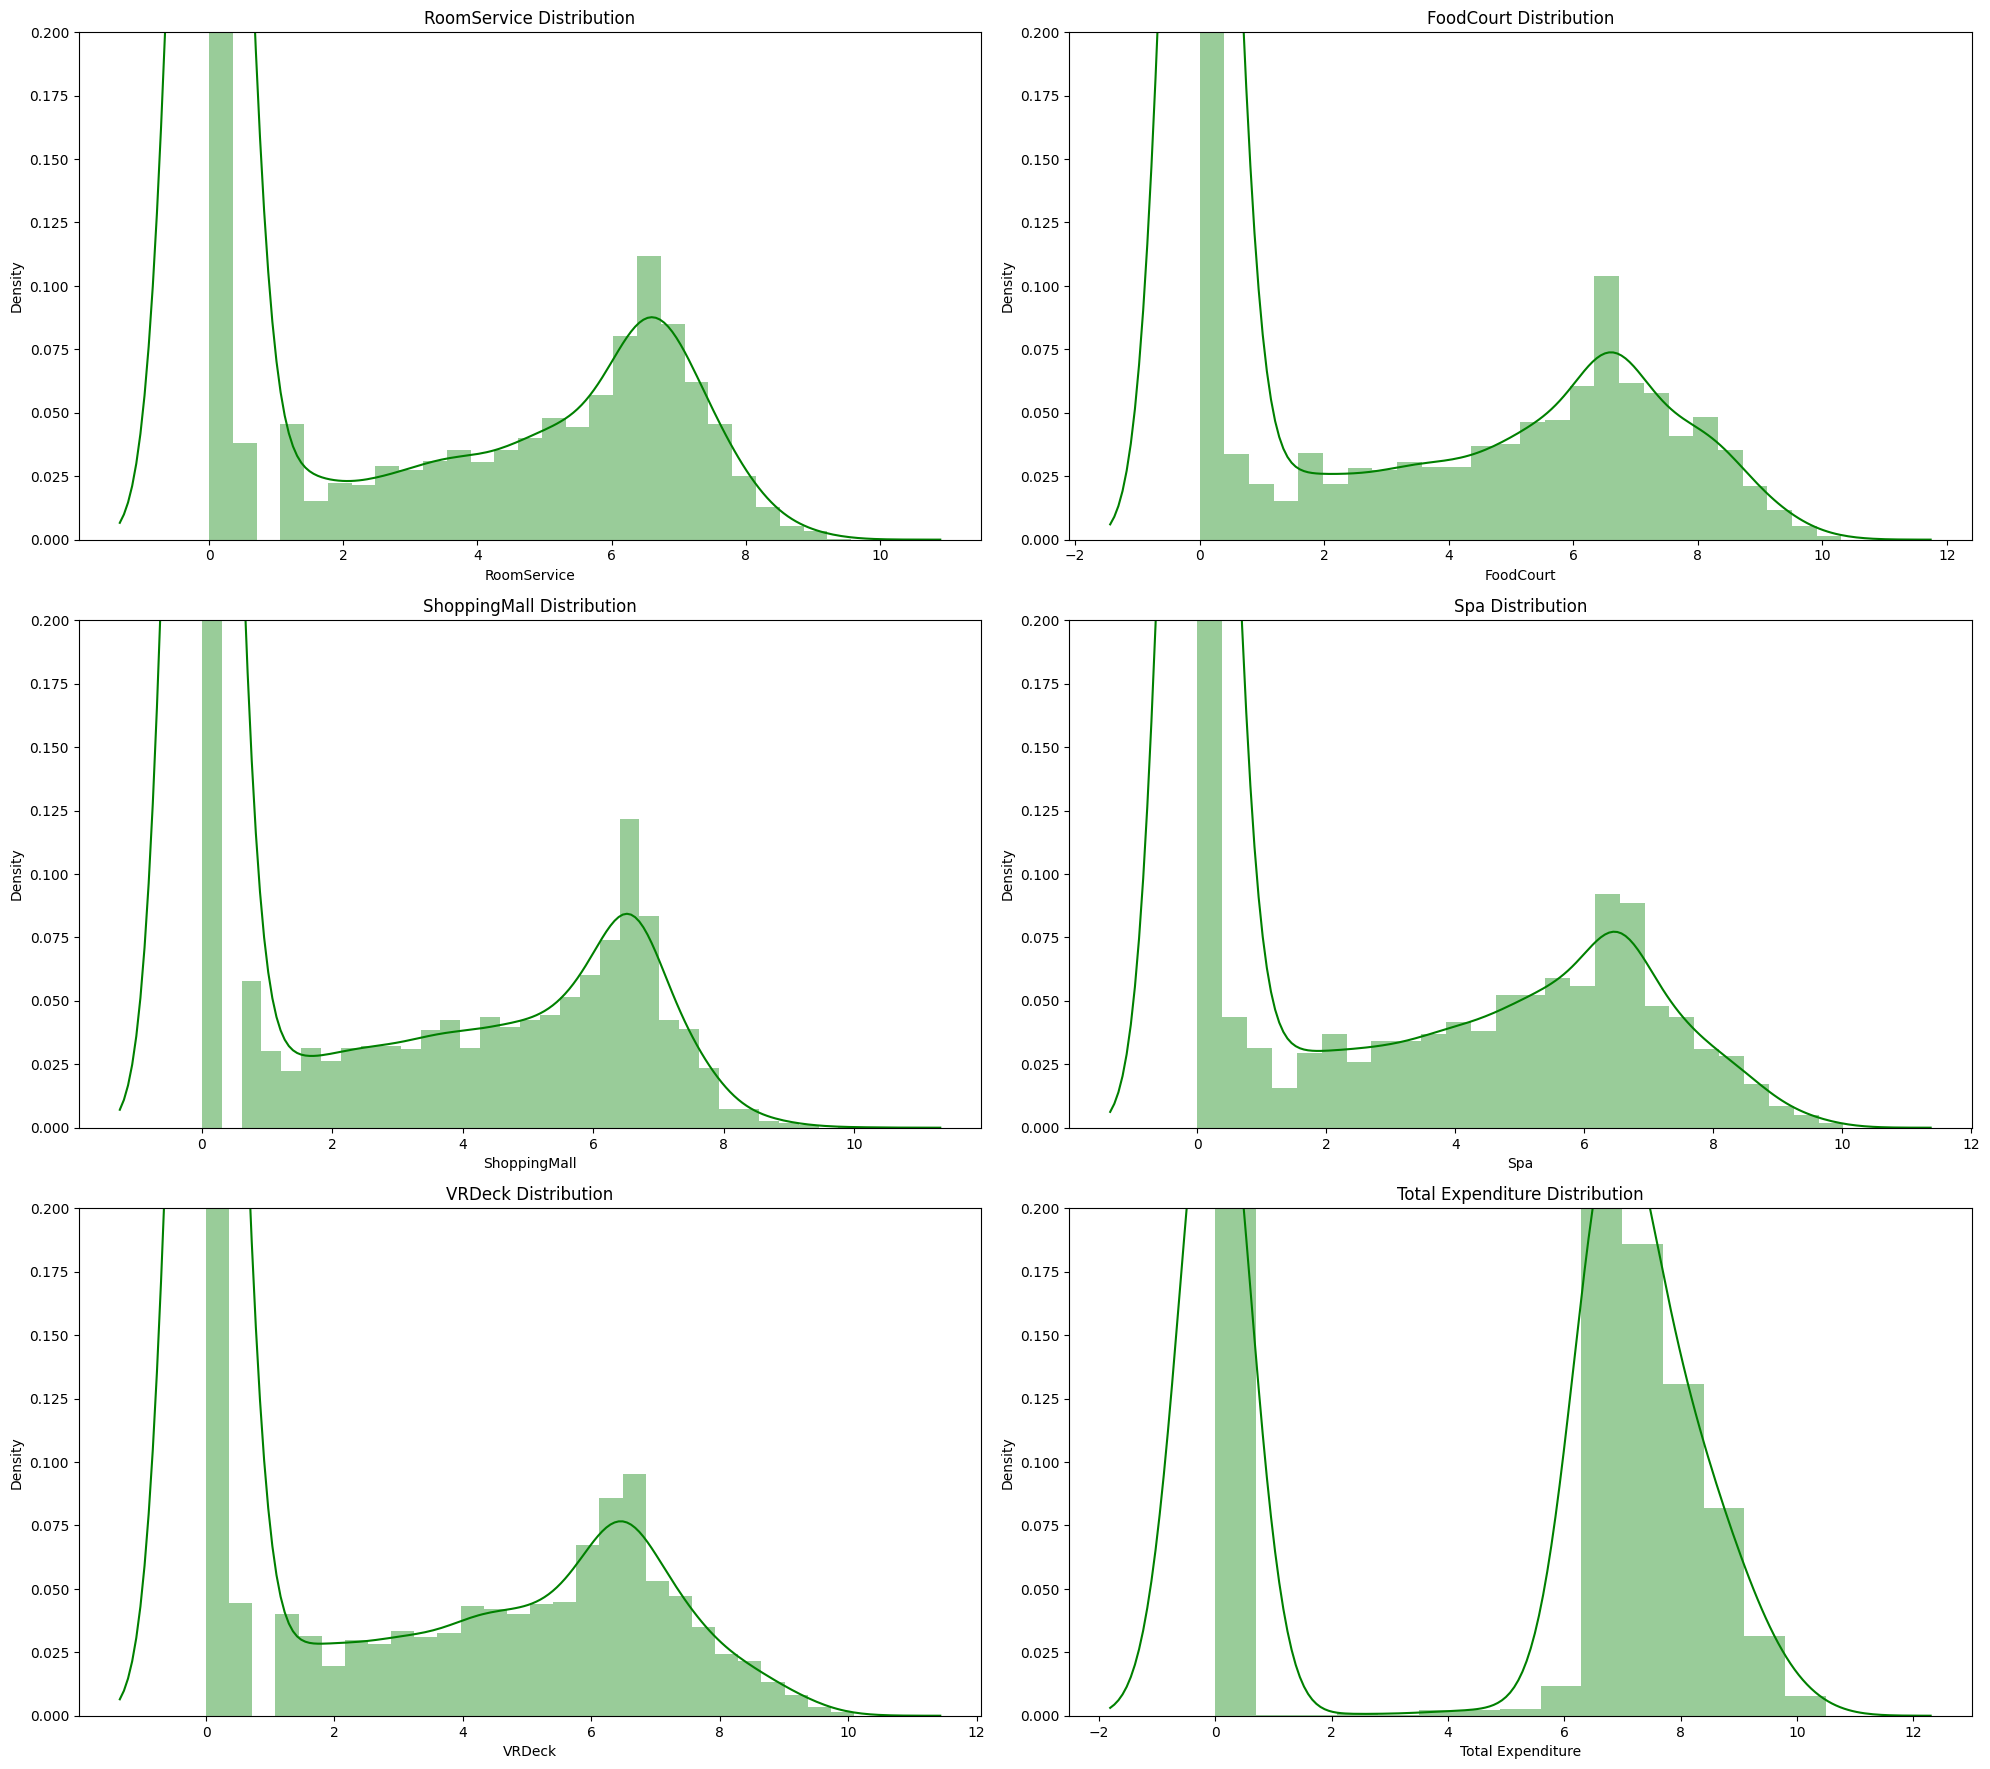

In [115]:
x=1

plt.figure(figsize=(20,35))
for i in cols:
    plt.subplot(6,2,x)
    sns.distplot(train_df[i],color="green")
    plt.ylim(0,0.2)
    plt.title(f"{i} Distribution")
    plt.tight_layout()
    x+=1

In [117]:
train_df.dtypes

#data all in correct types 

HomePlanet               object
CryoSleep                  bool
Destination              object
Age                     float64
VIP                        bool
RoomService             float64
FoodCourt               float64
ShoppingMall            float64
Spa                     float64
VRDeck                  float64
Transported                bool
Travelling_Solo            bool
Group_Size                int64
Cabin_Deck               object
Cabin_Side               object
Cabin_Region1              bool
Cabin_Region2              bool
Cabin_Region3              bool
Cabin_Region4              bool
Cabin_Region5              bool
Cabin_Region6              bool
Age Group                object
Total Expenditure       float64
No Spending                bool
Expenditure Category     object
dtype: object

In [118]:
test_df.dtypes

#data all in correct types

HomePlanet               object
CryoSleep                  bool
Destination              object
Age                     float64
VIP                        bool
RoomService             float64
FoodCourt               float64
ShoppingMall            float64
Spa                     float64
VRDeck                  float64
Travelling_Solo            bool
Group_Size                int64
Cabin_Deck               object
Cabin_Side               object
Cabin_Region1              bool
Cabin_Region2              bool
Cabin_Region3              bool
Cabin_Region4              bool
Cabin_Region5              bool
Cabin_Region6              bool
Age Group                object
Total Expenditure       float64
No Spending                bool
Expenditure Category     object
dtype: object

Feature encoding
- We will do one-hot encoding for nominal categorical variables
- We will do label encoding for ordinal categorical variables 

In [119]:
nominal_cat_cols = ["HomePlanet","Destination"]
ordinal_cat_cols = ["CryoSleep","VIP","Travelling_Solo","Cabin_Deck","Cabin_Side","Cabin_Region1","Cabin_Region2",
                    "Cabin_Region3","Cabin_Region4","Cabin_Region5","Cabin_Region6","Age Group","No Spending",
                    "Expenditure Category"]

In [122]:
enc = LabelEncoder()

train_df[ordinal_cat_cols] = train_df[ordinal_cat_cols].apply(enc.fit_transform)
test_df[ordinal_cat_cols] = test_df[ordinal_cat_cols].apply(enc.fit_transform)

In [123]:
train_df = pd.get_dummies(train_df,columns=nominal_cat_cols)
test_df = pd.get_dummies(test_df,columns=nominal_cat_cols)

In [124]:
#also need to encode the target feature in the training set 

train_df["Transported"].replace({False:0,True:1},inplace=True)

In [126]:
#checking features are encoded

pd.options.display.max_columns = None #displays all columns 
train_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Travelling_Solo,Group_Size,Cabin_Deck,Cabin_Side,Cabin_Region1,Cabin_Region2,Cabin_Region3,Cabin_Region4,Cabin_Region5,Cabin_Region6,Age Group,Total Expenditure,No Spending,Expenditure Category,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,39.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,1,1,0,1,0,0,0,0,0,4,0.000000,1,3,0,1,0,0,0,1
1,0,24.0,0,4.700480,2.302585,3.258097,6.309918,3.806662,1,1,1,5,1,1,0,0,0,0,0,2,6.602588,0,2,1,0,0,0,0,1
2,0,58.0,1,3.784190,8.182280,0.000000,8.812248,3.912023,0,0,2,0,1,1,0,0,0,0,0,5,9.248021,0,0,0,1,0,0,0,1
3,0,33.0,0,0.000000,7.157735,5.918894,8.110728,5.267858,0,0,2,0,1,1,0,0,0,0,0,4,8.551981,0,0,0,1,0,0,0,1
4,0,16.0,0,5.717028,4.262680,5.023881,6.338594,1.098612,1,1,1,5,1,1,0,0,0,0,0,1,6.995766,0,2,1,0,0,0,0,1


In [127]:
# selecting features for model training

X = train_df.drop(columns=["Transported"])
y = train_df[["Transported"]]

In [128]:
#scale data using standard scaler

scaler= StandardScaler()

X_scaled = scaler.fit_transform(X)
test_df_scaled = scaler.fit_transform(test_df)

In [131]:
#splitting data for model which needs scaled data

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

print(x_train.shape, y_train.shape)

print(x_test.shape,y_test.shape)


(6954, 28) (6954, 1)
(1739, 28) (1739, 1)


In [130]:
#splitting data for model which doesnt need scaled data 

x_train1, x_test1, y_train1, y_test1 = train_test_split(X_scaled,y,test_size=0.2,random_state=0)

print(x_train1.shape, y_train1.shape)

print(x_test1.shape, y_test1.shape)

(6954, 28) (6954, 1)
(1739, 28) (1739, 1)
